<a href="https://colab.research.google.com/github/emedema/id_humpback_whales/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import all necessary** **libraries** 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.preprocessing import image
from keras.applications.nasnet import NASNetLarge
# from keras.applications.resnet50 import preprocess_input,decode_predictions
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten
from keras.models import Model
from keras.utils import to_categorical

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

**SVM (Support Vector Machine)**

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

Goal of SVM
The goal of the SVM algorithm is to create the best line or decision boundary that can segregate n-dimensional space into classes so that we can easily put the new data point in the correct category in the future. This best decision boundary is called a hyperplane.

SVM chooses the extreme points/vectors that help in creating the hyperplane. These extreme cases are called as support vectors, and hence algorithm is termed as Support Vector Machine. Consider the below diagram in which there are two different categories that are classified using a decision boundary or hyperplane.

**Image file location** 

In [3]:
for dirname, _, filenames in os.walk(os.getcwd()+ "/drive/My Drive/datasets/"):
  print(dirname)

/content/drive/My Drive/datasets/
/content/drive/My Drive/datasets/preprocessingFiles
/content/drive/My Drive/datasets/test
/content/drive/My Drive/datasets/train


**Load in the training data**

In [4]:
#load the training data
trainData = pd.read_csv("drive/My Drive/datasets/train.csv")
#view the first five samples of train dataset
trainData.sample(5)

,Image,Id
23093,e8ca0c506.jpg,new_whale
18069,b591bd07e.jpg,new_whale
10840,6e0c053b7.jpg,new_whale
12788,812ea69cf.jpg,new_whale
1026,0a20d1ada.jpg,new_whale


**Group trainining data by the Number of Images**

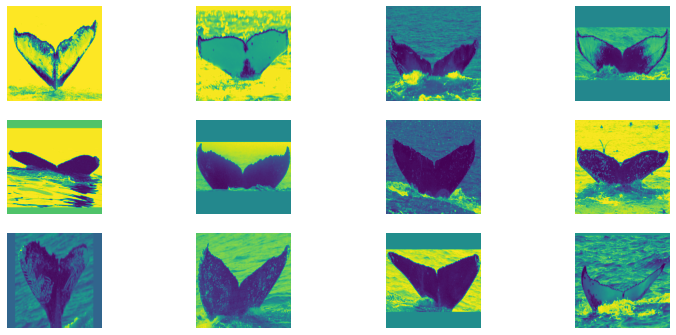

In [5]:
files = os.listdir(f'{dirname}')[50:62]

figure = plt.figure(figsize=(13, 8))
cols = len(files) // 4 + 1

for i in range(len(files)):
    subplot = figure.add_subplot(4, cols, i+1)
    subplot.axis('Off')
    img = plt.imread(f'{dirname}/{files[i]}')
    plt.imshow(img)

In [6]:
dataset_df = trainData.groupby('Id').agg('count').rename({'Image': 'NumImages'}, axis=1)
dataset_df.sort_values('NumImages', ascending=False, inplace=True)
dataset_df # View grouped data

,NumImages
Id,
new_whale,9664
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61
...,...
w_49ee8e0,1
w_49e0d44,1
w_49d1bcd,1


In [7]:
# remove new_whales
dataset_df.drop('new_whale', inplace=True)
dataset_df

,NumImages
Id,
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61
w_700ebb4,57
...,...
w_49ee8e0,1
w_49e0d44,1
w_49d1bcd,1


**Whale image thresholding and filtering**

In [8]:
img_thres = 30

img_df = dataset_df.query(f'NumImages > {img_thres}')

print('Shapes:', img_df.shape)
print('Total Images:', img_df.NumImages.sum())
img_df

Shapes: (28, 1)
Total Images: 1235


,NumImages
Id,
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61
w_700ebb4,57
w_3de579a,54
w_564a34b,51
w_fd3e556,50
w_88e4537,49


**Whales id used for identification**

In [9]:
classify_ids = list(img_df.index)

data_filtered = trainData.query(f'Id in {classify_ids}')
data_filtered 

,Image,Id
26,004e8ad5b.jpg,w_3de579a
32,00570db6b.jpg,w_9c506f6
52,008bf89fc.jpg,w_6822dbc
54,00910010d.jpg,w_700ebb4
61,009687166.jpg,w_778e474
...,...,...
25300,ff49c3124.jpg,w_f765256
25318,ff84b05fd.jpg,w_d405854
25339,ffad54783.jpg,w_f0fe284
25347,ffcd5efdc.jpg,w_f765256


**Slipt dataset into train and test set**

In [10]:
X, y =data_filtered.Image, data_filtered.Id
s = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
train_idx, test_idx = list(s.split(X, y))[0]
train_data = data_filtered.iloc[train_idx]
test_data = data_filtered.iloc[test_idx]

print('Images', 'Train: ',train_idx.shape,'Test:', test_idx.shape)

Images Train:  (926,) Test: (309,)


**As the data is large it will be better to use datagenerator, so here, keras Imagedatagenerator was utilized**

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255)
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         width_shift_range=0.1,
#         height_shift_range=0.1)

train_generator=train_datagen.flow_from_dataframe(
                                            dataframe=train_data,
                                            directory=dirname,
                                            x_col="Image",
                                            y_col="Id",
                                            batch_size=64,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(224,224))

Found 804 validated image filenames belonging to 28 classes.


In [14]:
valid_datagen = ImageDataGenerator(rescale=1./255)
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         width_shift_range=0.1,
#         height_shift_range=0.1)

valid_generator=valid_datagen.flow_from_dataframe(
                                            dataframe=test_data,
                                            directory=dirname,
                                            x_col="Image",
                                            y_col="Id",
                                            batch_size=64,
                                            class_mode="categorical",
                                            target_size=(224,224))

Found 268 validated image filenames belonging to 28 classes.


**Model Creation**

**NASNET model was created setting all layers except non trainable **

In [15]:
nasnet=NASNetLarge(include_top=True,weights='imagenet')

359748576/359748576 [==============================] - 3s 0us/step


In [16]:
x=nasnet.layers[-2].output
fc1=Dense(28, kernel_regularizer=tf.keras.regularizers.l2(0.02),activation='softmax')(x)

In [17]:
model=Model(inputs=nasnet.input,outputs=fc1)

**NASNET Model Summary**

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                             

To convert NASNET into SVM; there is a parameter called  “kernel_regularizer” and inside this regularizer, l1 or l2 norm could be utilized. Here l2 norm is used using linear as activation function and was employed in the final output layer in the model creation section.

Because when Support Vector Machine is used for binary classification LinearSVM is used. Linear SVM means a line is drawn between them which try to find out other margin lines  and then divide the particular classes. 

For multiclass classification, softmax is employed as an activation function for SVM 



In [19]:
from keras.optimizers import Adam
adam=Adam(learning_rate=0.01)
for lr in model.layers[:-5]:
    #print(l)
    lr.trainable = False

For Multiclass classification problem  squared_hinge is used as loss function and softmax as activation function during compiling for SVM is given as:

model.add(Dense(number_of_classes,kernel_regularizers = l2(0.01),activation= “softmax”))
model.compile(optimizer=”adam”,loss=”squared_hinge”, metrics = [‘accuracy’])

In [20]:
model.compile(optimizer='adam',loss ='squared_hinge',metrics=["accuracy"])
model.fit_generator(train_generator,steps_per_epoch=804//64,validation_data=valid_generator,validation_steps=268//64,epochs=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/4
12/12 [==============================] - 551s 45s/step - loss: 1.8040 - accuracy: 0.0554 - val_loss: 1.4431 - val_accuracy: 0.1055
Epoch 2/4
12/12 [==============================] - 522s 45s/step - loss: 1.2843 - accuracy: 0.1189 - val_loss: 1.1565 - val_accuracy: 0.1367
Epoch 3/4
12/12 [==============================] - 522s 44s/step - loss: 1.1126 - accuracy: 0.1270 - val_loss: 1.0804 - val_accuracy: 0.1445
Epoch 4/4
12/12 [==============================] - 547s 47s/step - loss: 1.0727 - accuracy: 0.1380 - val_loss: 1.0692 - val_accuracy: 0.1328


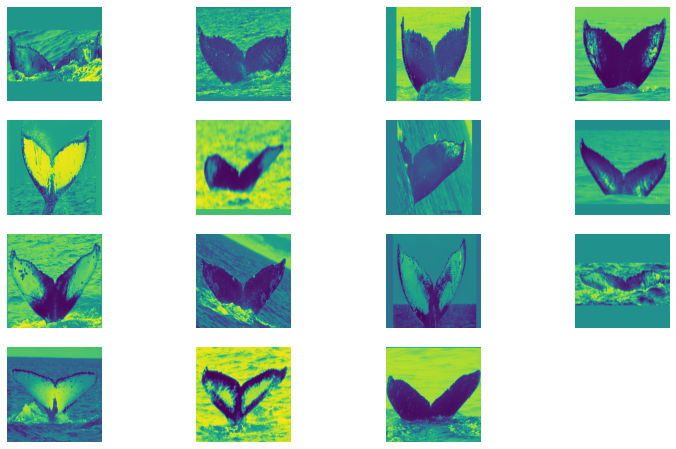

In [21]:
files = os.listdir(f'{dirname}')[15:30]

figure = plt.figure(figsize=(13, 8))
cols = len(files) // 4 + 1

for i in range(len(files)):
    subplot = figure.add_subplot(4, cols, i+1)
    subplot.axis('Off')
    img = plt.imread(f'{dirname}/{files[i]}')
    plt.imshow(img)

In [22]:
# Training the nasnet on the Training set and evaluating it on the Test set
#r=model.fit(x = train_data, validation_data = test_data, epochs = 15)

In [23]:
model.save('model.h5')

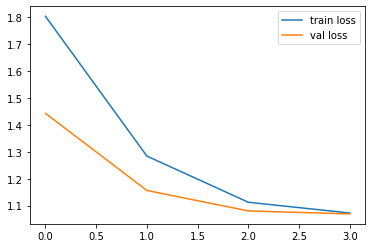

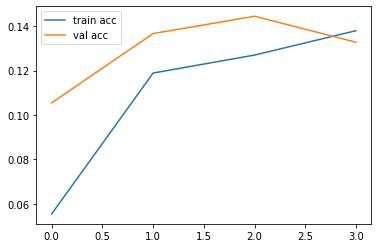

<Figure size 432x288 with 0 Axes>

In [24]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(model.history.history['accuracy'], label='train acc')
plt.plot(model.history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [25]:
# load model
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                             

In [27]:
#from sklearn.svm import SVC
#svm = SVC(kernel='rbf')

#svm.fit(train_generator,np.argmax(valid_generator, axis=1))

#print("Done")